# BIP Smart Grid 2025 - Lecture Prof. Hesse: Arbitrage

In [139]:
import pandas as pd
import pyomo.environ as opt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [140]:
pd.options.plotting.backend = "plotly"
template = "plotly_white"

## Data

In [141]:
df = pd.read_csv("../data/arbitrage_MDPI2019.csv", index_col=0, parse_dates=True)
dt = 0.25

In [142]:
df.plot(template=template, line_shape="hv", labels={"value": "Price / €/MWh"})

## Optimization model

In [143]:
storage = dict(
    capacity = 1, # MWh
    soc_init = 0.5,
    soc_min = 0.1,
    soc_max = 0.9,
    erate_ch = 1,
    erate_dch = 1,
    eff_ch = 0.95,
    eff_dch = 0.95,
    max_cycles = 10.5
)

In [144]:
def build_arbitrage_model(storage_params, profile, dt):
    # build model
    model = opt.ConcreteModel()
    
    # === Sets ====
    n = len(df) #number of timesteps
    
    model.time = opt.RangeSet(0, n-1)

    # === Parameters ===
    capacity = storage_params["capacity"]
    soc_init = storage_params["soc_init"]
    soc_min = storage_params["soc_min"]
    soc_max = storage_params["soc_max"]
    erate_ch = storage_params["erate_ch"]
    erate_dch = storage_params["erate_dch"]
    eff_ch = storage_params["eff_ch"]
    eff_dch = storage_params["eff_dch"]
    max_cycles = storage_params["max_cycles"]

    # === Variables ===
    model.bess_energy = opt.Var(model.time, domain=opt.NonNegativeReals)
    model.power_ch = opt.Var(model.time, domain=opt.NonNegativeReals)
    model.power_dch = opt.Var(model.time, domain=opt.NonNegativeReals)
    model.cyclecount = opt.Var(within=opt.NonNegativeReals)
    # === Objective ===
    def objective_rule(m):
        return sum((m.power_dch[t] - m.power_ch[t]) * dt * profile.price[t] for t in model.time)

    model.obj = opt.Objective(sense=opt.maximize, rule=objective_rule)

    # === Constraints ===
    def power_charge_limit_rule(m, t):
        return m.power_ch[t] <= capacity * erate_ch

    def power_discharge_limit_rule(m, t):
        return m.power_dch[t] <= capacity * erate_dch

    def energy_max_rule(m, t):
        return m.bess_energy[t] <= capacity * soc_max

    def energy_min_rule(m, t):
        return m.bess_energy[t] >= capacity * soc_min

    def energy_throughput_rule(m):
        return sum(m.power_dch[t] + m.power_ch[t] for t in m.time)*dt == 2 * m.cyclecount

    def cyclecount_rule(m):
        return m.cyclecount <= max_cycles
    
    def soc_balance_rule(m, t):
        if t == m.time.first():
            return m.bess_energy[t] == capacity * soc_init + m.power_ch[t] * eff_ch * dt - m.power_dch[t] * (1/eff_dch) * dt
        else:
            return m.bess_energy[t] == m.bess_energy[t-1] + m.power_ch[t] * eff_ch * dt - m.power_dch[t] * (1/eff_dch) * dt

    def soc_end_rule(m):
        return m.bess_energy[m.time.last()] >= capacity * soc_init

    model.constraint_power_charge_limit    = opt.Constraint(model.time, rule=power_charge_limit_rule)
    model.constraint_power_discharge_limit = opt.Constraint(model.time, rule=power_discharge_limit_rule)
    model.constraint_energy_max            = opt.Constraint(model.time, rule=energy_max_rule)
    model.constraint_energy_min            = opt.Constraint(model.time, rule=energy_min_rule)
    model.constraint_soc_balance           = opt.Constraint(model.time, rule=soc_balance_rule)
    model.constraint_soc_end               = opt.Constraint(rule=soc_end_rule)
    model.constraint_max_fec               = opt.Constraint(rule=energy_throughput_rule)
    model.constraint_cyclecount            = opt.Constraint(rule=cyclecount_rule)
    

    return model

## Results and analysis

In [145]:
solver = opt.SolverFactory("glpk", tee=True)

In [146]:
model = build_arbitrage_model(storage, df, dt)
solver.solve(model, tee=False)

{'Problem': [{'Name': 'unknown', 'Lower bound': 685.966888448985, 'Upper bound': 685.966888448985, 'Number of objectives': 1, 'Number of constraints': 3363, 'Number of variables': 2017, 'Number of nonzeros': 6722, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.1291368007659912}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [147]:
# write results in dataframe
capacity = storage["capacity"]

df["power"] = [opt.value(model.power_ch[t]) - opt.value(model.power_dch[t]) for t in model.time]
df["soc"] = [opt.value(model.bess_energy[t]) / capacity for t in model.time]
# Add a column "cycles" to the DataFrame
df["cycles"] = df["power"].cumsum() * dt # Multiply by dt (time step) to account for cumulative energy throughput

In [148]:
def plot_bess_power(df, **kwargs):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.update_layout(**kwargs)

    fig.add_trace(go.Scatter(x=df.index, y=df["power"], name="power", line_shape="hv"))
    fig.update_yaxes(title="Power [MW]")
    fig.add_trace(go.Scatter(x=df.index, y=df["soc"], name="SOC", line_shape="hv"))
    fig.update_yaxes(title="SOC")

    fig.add_trace(go.Scatter(x=df.index, y=df["price"], name="price", line_shape="hv"), secondary_y=True)
    fig.update_yaxes(title="Price [€/MWh]", secondary_y=True)

    return fig

In [149]:
plot_bess_power(df, template=template)

In [150]:
def plot_profit(df, **kwargs):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.update_layout(**kwargs)

    fig.add_trace(go.Scatter(x=df.index, y=df["power"], name="power", line_shape="hv"))
    fig.update_yaxes(title="Power [MW]")
    fig.add_trace(go.Scatter(x=df.index, y=df["soc"], name="SOC", line_shape="hv"))
    fig.update_yaxes(title="SOC")

    fig.add_trace(go.Scatter(x=df.index, y=df["price"], name="price", line_shape="hv"), secondary_y=True)
    fig.update_yaxes(title="Price [€/MWh]", secondary_y=True)

    return fig

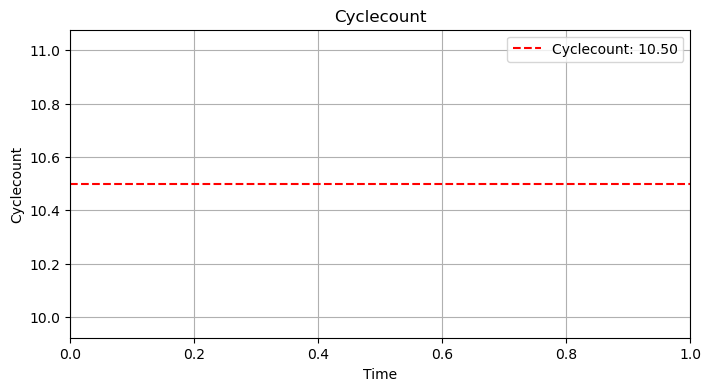

In [151]:
# Extract the value of cyclecount from the model
cyclecount_value = opt.value(model.cyclecount)

# Plot cyclecount as a horizontal line
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.axhline(y=cyclecount_value, color='r', linestyle='--', label=f"Cyclecount: {cyclecount_value:.2f}")
plt.title("Cyclecount")
plt.xlabel("Time")
plt.ylabel("Cyclecount")
plt.legend()
plt.grid()
plt.show()